In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

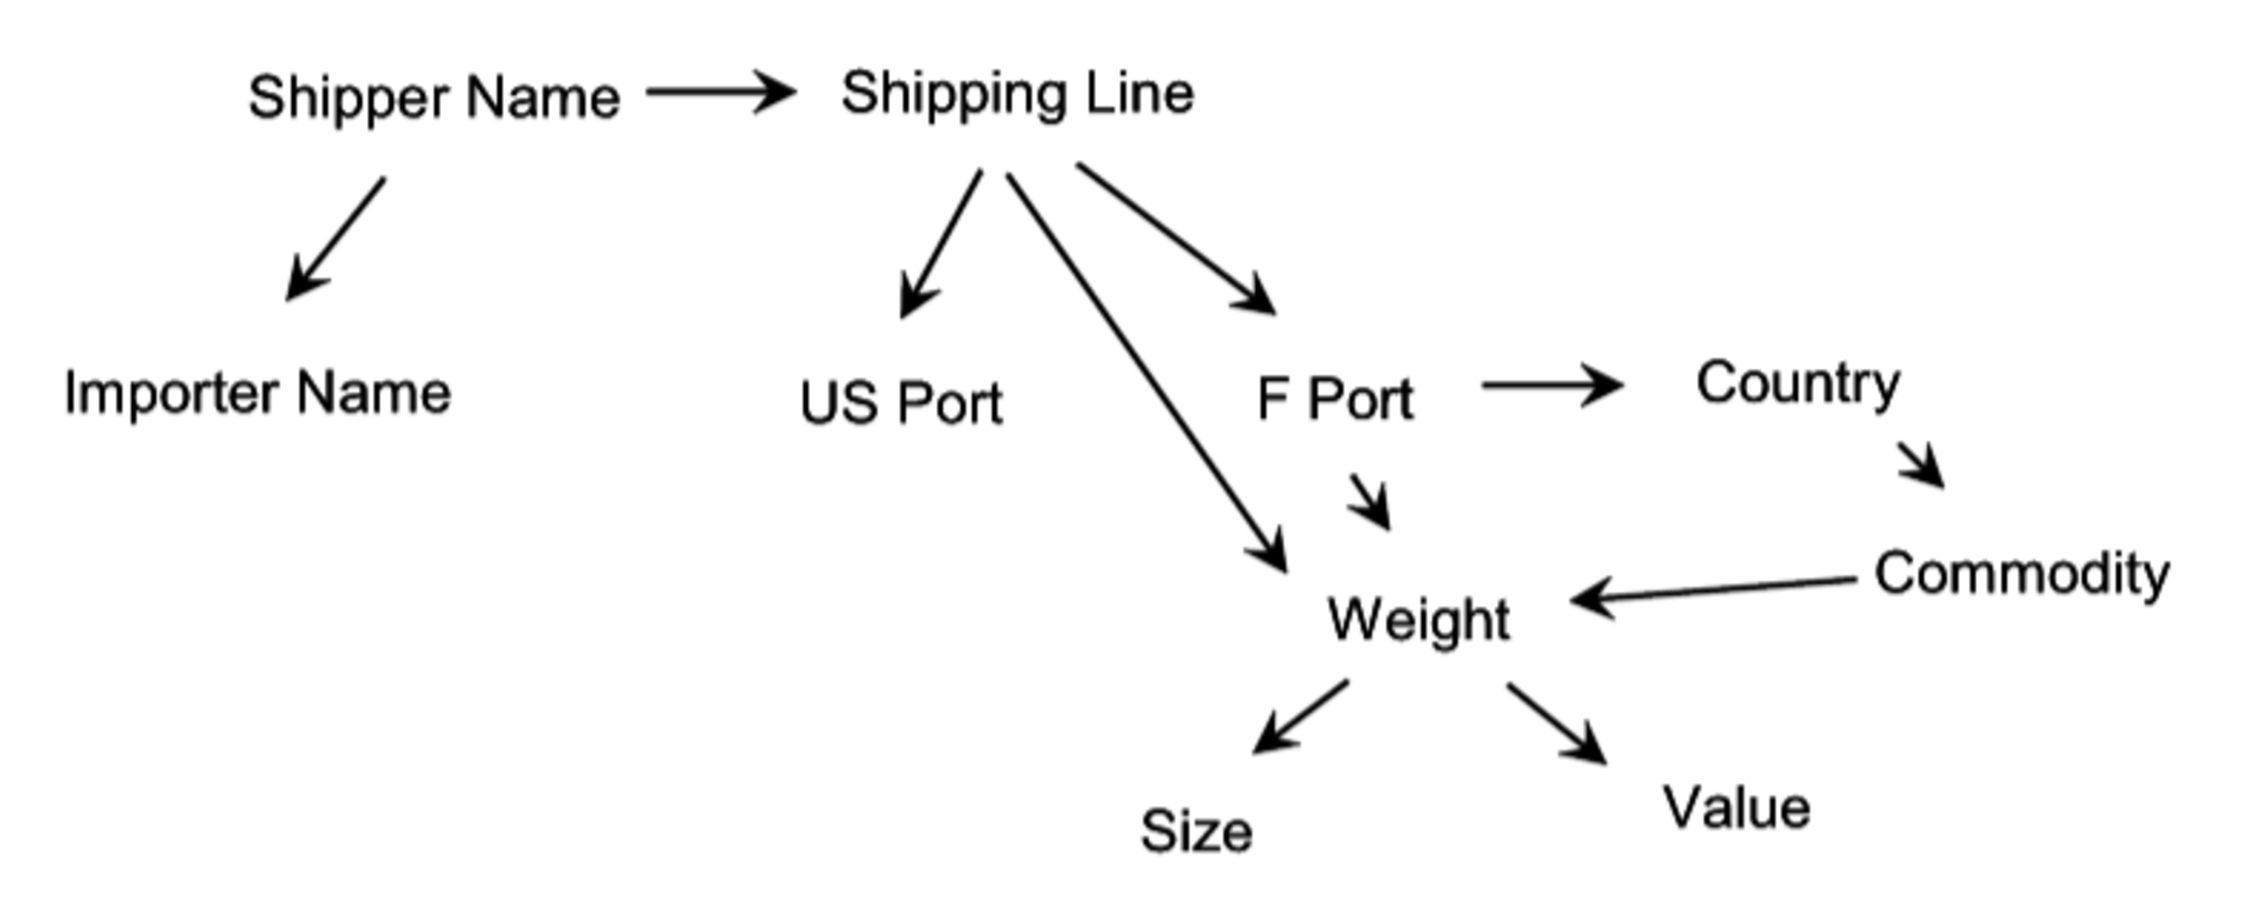

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)? True

CI (Shipper Name, Value | Shipping Line)? True

CI (Foreign Port, Commodity | Country)? True

CI (Foreign Port, Commodity | County, Weight)? False

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (70%), ASCO (30%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (80%), Los Angeles (20%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (50%), Heavy (20%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (30%), Heavy (60%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (70%), Heavy (15%)

Which of the following packages is most anomalous?

a) A heavy package shipped from Vancouver to Seattle by ASCO

b) A heavy package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

Pr(a) = Pr(Shipping Line : ASCO)\*Pr(Foreign Port | Shipping Line = ASCO: Vancouver)\*Pr(US Port | Shipping Line = ASCO: Seattle)\*Pr(Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Heavy)
      = 30% * 100% * 100% * 15% = 4.5%


Pr(b) = Pr(Shipping Line : CSCO)\*Pr(Foreign Port | Shipping Line = CSCO: Vancouver)\*Pr(US Port | Shipping Line = CSCO: Seattle)\*Pr(Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Heavy)
      = 70% * 60% * 80% * 20% = 6.72%

Pr(c) = Pr(Shipping Line : CSCO)\*Pr(Foreign Port | Shipping Line = CSCO: Yokohama)\*Pr(US Port | Shipping Line = CSCO: Loa Angeles)\*Pr(Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Heavy)
      = 70% * 40% * 20% * 60% = 3.36%

### Thus, c) A heavy package shipped from Yokohama to Los Angeles by CSCO is the most anomalous one.

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [3]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,0,0,0,1,0,1
2,1,1,0,1,1,1
3,1,0,0,1,1,1
4,2,0,1,0,1,1


a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [4]:
# your answers here
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.estimators import BayesianEstimator
hc = HillClimbSearch(train, scoring_method=BicScore(train))
best_model = hc.estimate()
print(best_model.edges())

[('B', 'A'), ('D', 'A'), ('E', 'A')]


In [5]:
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print('CPD of %s:'%str(cpd.variable))
    print(cpd)
print(best_model.local_independencies(best_model.nodes()))

CPD of A:
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| B    | B(0)                 | B(0)                  | B(0)                 | B(0)                 | B(1)                  | B(1)                 | B(1)                  | B(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| D    | D(0)                 | D(0)                  | D(1)                 | D(1)                 | D(0)                  | D(0)                 | D(1)                  | D(1)                 |
+------+----------------------+-----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+----------------------+
| E    | E

In [6]:
from collections import defaultdict
from pgmpy.inference import VariableElimination
def temp_predict(model,data):
    missing_variables = list(set(model.nodes()) - set(data.columns))
    pred_values = defaultdict(list)
    model_inference = VariableElimination(model)
    for index, data_point in data.iterrows():
        states_dict = model_inference.map_query(variables=missing_variables, evidence=data_point.astype(int).to_dict())
        for k, v in states_dict.items():
            pred_values[k].append(v)
    return pd.DataFrame(pred_values, index=data.index)

train_x = train.loc[:,"B":"F"]
predicted_train = temp_predict(best_model, train_x)
print ("In sample:",(train.loc[:,'A']==predicted_train['A']).mean())

test_x = test.loc[:,"B":"F"]
predicted_test = temp_predict(best_model, test_x)
print ("Out of sample:",(test.loc[:,'A']==predicted_test['A']).mean())

In sample: 0.5766666666666667
Out of sample: 0.5645


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [52]:
from sklearn.cluster import KMeans
data3=pd.read_csv("HW3Q3_1.csv")
X = np.array(data3[data3.columns[9:33]])
kmeans = KMeans(n_clusters=3, random_state=14).fit(X)
data3['CrimeLabel'] = kmeans.labels_

### a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster. (5 pts)

In [53]:
ClusterHourMean = data3.groupby(['CrimeLabel']).mean()[data3.columns[9:33]]

Text(0.5, 1.0, "Each Cluster's Mean Value for Hour of Day  Figure 3-1")

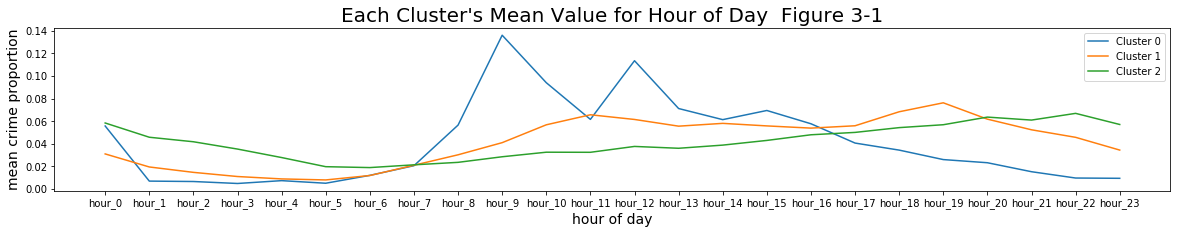

In [54]:
fig = plt.figure(figsize=(20,3))
plt.plot(ClusterHourMean.iloc[0],label='Cluster 0')
plt.plot(ClusterHourMean.iloc[1],label='Cluster 1')
plt.plot(ClusterHourMean.iloc[2],label='Cluster 2')
plt.legend()
plt.xlabel('hour of day',fontsize=14)
plt.ylabel('mean crime proportion',fontsize=14)
plt.title("Each Cluster's Mean Value for Hour of Day  Figure 3-1",fontsize=20)

### b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

#### Fig 3-1. In this plot, we can tell that the mean crime proportion of cluster 1 and cluster 2 in 24 hour of a day are relatively more stable than cluster 0. For cluster 0, there are three obvious peaks: two high peaks in 9:00 am and 12:00 pm and start to decrease, and one low peak value in 11:00 am. For cluster 1 and cluster 2, there is no dramaticly increase or decrease. 

### c) Do you notice any consistent trends about which crime types are assigned to which cluster? Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)

In [55]:
CrimeTypeCluster = data3[['crime_type','CrimeLabel']]
CrimeTypeCluster['CrimeType'] = CrimeTypeCluster.apply(lambda x:x['crime_type'].split(':')[0],axis=1)
del CrimeTypeCluster['crime_type']
CrimeTypeCluster.head()

,CrimeLabel,CrimeType
0,2,ARSON
1,2,ASSAULT
2,2,ASSAULT
3,1,ASSAULT
4,2,ASSAULT


In [56]:
print(CrimeTypeCluster[CrimeTypeCluster['CrimeLabel']==0].CrimeType.value_counts(normalize=True))
print('----------------------------------------------------------------------------------')
print(CrimeTypeCluster[CrimeTypeCluster['CrimeLabel']==1].CrimeType.value_counts(normalize=True))
print('----------------------------------------------------------------------------------')
print(CrimeTypeCluster[CrimeTypeCluster['CrimeLabel']==2].CrimeType.value_counts(normalize=True))

DECEPTIVE PRACTICE        0.666667
OTHER OFFENSE             0.083333
ASSAULT                   0.083333
BATTERY                   0.083333
PUBLIC PEACE VIOLATION    0.083333
Name: CrimeType, dtype: float64
----------------------------------------------------------------------------------
OTHER OFFENSE                       0.277778
NARCOTICS                           0.222222
THEFT                               0.129630
OFFENSE INVOLVING CHILDREN          0.055556
CRIMINAL TRESPASS                   0.055556
DECEPTIVE PRACTICE                  0.055556
BATTERY                             0.037037
ASSAULT                             0.037037
BURGLARY                            0.037037
SEX OFFENSE                         0.018519
WEAPONS VIOLATION                   0.018519
GAMBLING                            0.018519
PUBLIC PEACE VIOLATION              0.018519
INTERFERENCE WITH PUBLIC OFFICER    0.018519
Name: CrimeType, dtype: float64
------------------------------------------------

#### According to the value count result above, the DECEPTIVE PRACTICE  is the domain crime in cluster 0, OTHER OFFENSE              and NARCOTICS are the domain crimes in cluster 1, and battery and robbery are the domain crimes in cluster 2.

### d) Do the three clusters have different day-of-week trends? Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences. (5 pts)

Text(0.5, 1.0, "Each Cluster's Mean Value for Day of Week  Figure 3-2")

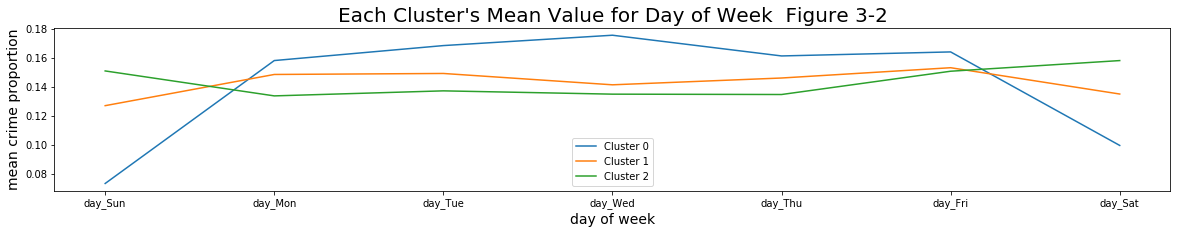

In [57]:
fig = plt.figure(figsize=(20,3))
plt.plot(data3.groupby(['CrimeLabel']).mean()[data3.columns[2:9]].iloc[0],label='Cluster 0')
plt.plot(data3.groupby(['CrimeLabel']).mean()[data3.columns[2:9]].iloc[1],label='Cluster 1')
plt.plot(data3.groupby(['CrimeLabel']).mean()[data3.columns[2:9]].iloc[2],label='Cluster 2')
plt.legend()
plt.xlabel('day of week',fontsize=14)
plt.ylabel('mean crime proportion',fontsize=14)
plt.title("Each Cluster's Mean Value for Day of Week  Figure 3-2",fontsize=20)

#### Fig 3-2. This plot shows that increase or decrease, all the mean proportion of three clusters change significantly in Friday and Monday. Cluster 0 and cluster 1 increase, and cluster 2 decrease. During the weekdays, the cluster 0 has the highest proportion and cluster 2 has the lowest proportion. But in weekends, cluster 2 has the highest proportion and cluster 0 has the lowest proportion.

Text(0.5, 1.0, "Each Cluster's Mean Value for Different Neighborhoods  Figure 3-3")

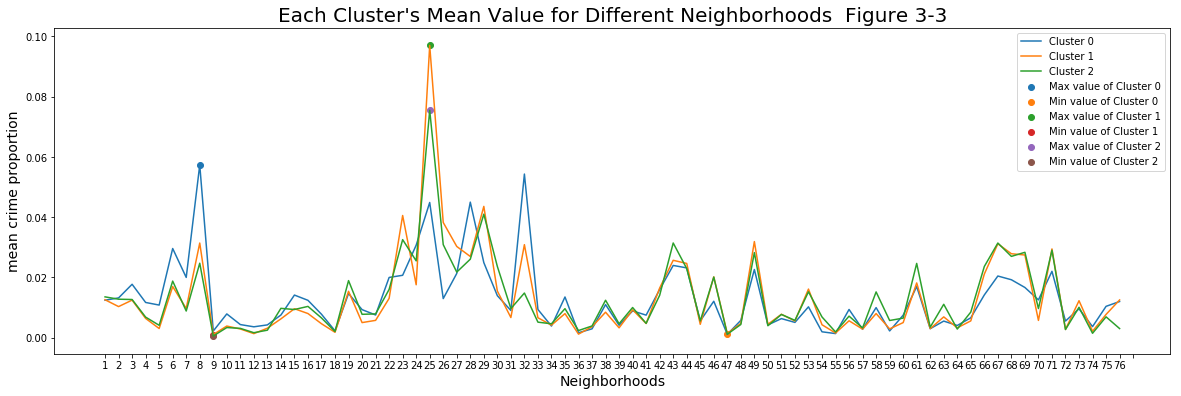

In [58]:
fig = plt.figure(figsize=(20, 6))
for i in range(0,3):
    plt.plot(data3.groupby(['CrimeLabel']).mean()[data3.columns[33:109]].iloc[i],label='Cluster %s'%i)
    plt.scatter(np.array(data3.groupby(['CrimeLabel']).mean()[data3.columns[33:109]].iloc[i]).argmax(),np.array(data3.groupby(['CrimeLabel']).mean()[data3.columns[33:109]].iloc[i]).max(),label='Max value of Cluster %s'%i)
    plt.scatter(np.array(data3.groupby(['CrimeLabel']).mean()[data3.columns[33:109]].iloc[i]).argmin(),np.array(data3.groupby(['CrimeLabel']).mean()[data3.columns[33:109]].iloc[i]).min(),label='Min value of Cluster %s'%i)
plt.legend()
plt.xlabel('Neighborhoods',fontsize=14)
plt.ylabel('mean crime proportion',fontsize=14)
plt.xticks(range(0,77),range(1,77))
plt.title("Each Cluster's Mean Value for Different Neighborhoods  Figure 3-3",fontsize=20)

#### Fig 3-3. This plot shows that, generally, the value of three clusters' average proportion in different neighborhoods are similar. In other words, for most neighborhoods, when the cluster 0 crimes mean proportion is high in a neighborhood, the value for cluster 1 and cluster 2 crimes are usually high as well. Except neighborhood 8, 25, 26, 32 and 67. 

### e) Do the three clusters affect different types of communities/neighborhoods? To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster. You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.). You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

In [63]:
CrimeCluster = data3.groupby(['CrimeLabel'],as_index=False).mean()[data3.columns[33:109]].T.reset_index()
CrimeCluster['Community'] = CrimeCluster.apply(lambda x: x['index'].split('_')[2], axis=1)
CrimeCluster.rename(columns={0:'CrimeCluster0',1:'CrimeCluster1',2:'CrimeCluster2'}, inplace=True)
CrimeCluster = CrimeCluster[['CrimeCluster0','CrimeCluster1','CrimeCluster2','Community']]
CrimeCluster['Community'] = CrimeCluster['Community'].astype('int')
CommunityCrime = CrimeCluster.merge(data4, left_on='Community', right_on='Community Area Number')
del CommunityCrime['Community Area Number']
del CommunityCrime['centroid_x']
del CommunityCrime['centroid_y']

In [87]:
CrimeCluster0Max = CrimeCluster.nlargest(1, 'CrimeCluster0')[['Community','CrimeCluster0']]
CrimeCluster0Max = CrimeCluster0Max.merge(data4, left_on='Community', right_on='Community Area Number')
CrimeCluster1Max = CrimeCluster.nlargest(1, 'CrimeCluster1')[['Community','CrimeCluster1']]
CrimeCluster1Max = CrimeCluster1Max.merge(data4, left_on='Community', right_on='Community Area Number')
CrimeCluster2Max = CrimeCluster.nlargest(1, 'CrimeCluster2')[['Community','CrimeCluster2']]
CrimeCluster2Max = CrimeCluster2Max.merge(data4, left_on='Community', right_on='Community Area Number')

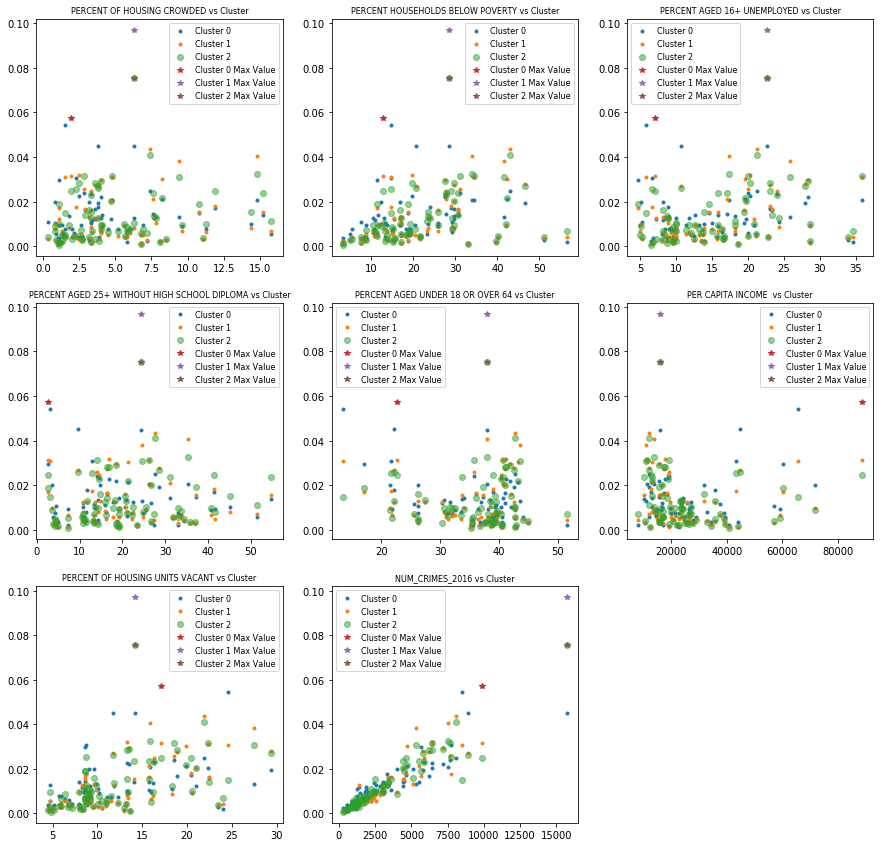

In [93]:
fig = plt.figure(figsize=(15,20))
for i,j in enumerate(CommunityCrime.columns[5:]):
    ax = fig.add_subplot(4,3,i+1)
    ax.set_title(str(j)+' vs Cluster', fontsize=8)
    ax.plot(CommunityCrime[j], CommunityCrime['CrimeCluster0'],'.',label='Cluster 0')
    ax.plot(CommunityCrime[j], CommunityCrime['CrimeCluster1'],'.',label='Cluster 1')
    ax.plot(CommunityCrime[j], CommunityCrime['CrimeCluster2'],'o', alpha=0.5,label='Cluster 2')
    ax.plot(CrimeCluster0Max[j], CrimeCluster0Max['CrimeCluster0'],'*',label='Cluster 0 Max Value')
    ax.plot(CrimeCluster1Max[j], CrimeCluster1Max['CrimeCluster1'],'*',label='Cluster 1 Max Value')
    ax.plot(CrimeCluster2Max[j], CrimeCluster2Max['CrimeCluster2'],'*',label='Cluster 2 Max Value')
    ax.legend(fontsize=8)

#### Fig 3-3. This series of plots shows the the distribution of each community characteristic and the proportion of each cluster. Stars mark the highest value in each cluster. The max proportion of three clusters lie in three different cummunities. Apparently, the value of NUM_CRIMES_2016 is positively related the proportion of all the three crime clusters, and the values of NUM_CRIMES_2016 in three communities which have max crime cluster proportion are significantly higher than the rest. In cluster 0, the values of PERCENT of HOUSING CROWDED, PERCENT HOUSEHOLDS BELOW POVERTY, PERCENT HOUSEHOLDS BELOW POVERTY, 'PERCENT AGED 16+ UNEMPLOYED, PER CAPITA INCOME community which has the max proportion value are significantly lower than the rest. In cluster 1, the value of PER CAPITA INCOME community which has the max proportion value is lower than the rest. 

### f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

In [99]:
CrimeDivisionCluster = data3[['Category','CrimeLabel']]
print(CrimeDivisionCluster[CrimeDivisionCluster['CrimeLabel']==0].Category.value_counts(normalize=True))
print('----------------------------------------------------------------------------------')
print(CrimeDivisionCluster[CrimeDivisionCluster['CrimeLabel']==1].Category.value_counts(normalize=True))
print('----------------------------------------------------------------------------------')
print(CrimeDivisionCluster[CrimeDivisionCluster['CrimeLabel']==2].Category.value_counts(normalize=True))

P2    1.0
Name: Category, dtype: float64
----------------------------------------------------------------------------------
P2     0.796296
P1P    0.166667
P1V    0.037037
Name: Category, dtype: float64
----------------------------------------------------------------------------------
P2     0.471698
P1V    0.415094
P1P    0.113208
Name: Category, dtype: float64


#### From the value counts result abouve, we can tell that the only crime category in cluster 0 is P2, and both cluster 1 and cluster 2 contain all the three crime categories. In cluster 1, P2 is the domain crime category. In cluster 2, there is no domain category.

In [10]:
# apply kmeans on the community characteristic, to correspond to three crime cluster, group 
data4=pd.read_csv("HW3Q3_2.csv")
X = np.array(data4[data4.columns[4:12]])
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
data4['CharacteristicLabel'] = kmeans.labels_

In [13]:
Crime_Chara = CommunityCrime[['CrimeCluster0','CrimeCluster1','CrimeCluster2','CharacteristicLabel']]
Crime_Chara.groupby(['CharacteristicLabel']).mean()

,CrimeCluster0,CrimeCluster1,CrimeCluster2
CharacteristicLabel,,,
0,0.030256,0.016456,0.012758
1,0.011726,0.015225,0.015577
2,0.010970,0.007069,0.007307


#### This tabel shows that communities in characteritic cluster 0 have high proportion in crime cluster 0 and cluster 1, and communities in characteritic cluster 1 have high proportion in crime cluster 2.

In [14]:
CommunityCrime.head()

,CrimeCluster0,CrimeCluster1,CrimeCluster2,Community,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016,CharacteristicLabel
0,0.012457,0.012605,0.013562,1,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420,1
1,0.013220,0.010340,0.012788,2,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068,1
2,0.017743,0.012486,0.012691,3,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330,2
3,0.011709,0.006408,0.006845,4,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859,2
4,0.010844,0.003062,0.004130,5,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280,0


In [28]:
CrimeCluster0Max = CrimeCluster.nlargest(1, 'CrimeCluster0')[['Community','CrimeCluster0']]
CrimeCluster0Max = CrimeCluster0Max.merge(data4, left_on='Community', right_on='Community Area Number')
CrimeCluster0Min = CrimeCluster.nlargest(1, 'CrimeCluster0')[['Community','CrimeCluster0']]
CrimeCluster0Min = CrimeCluster0Min.merge(data4, left_on='Community', right_on='Community Area Number')
CrimeCluster0Max

,Community,CrimeCluster0,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016,CharacteristicLabel
0,8,0.057348,8,Near North Side,1175512.220,1906089.147,1.9,12.9,7.0,2.5,22.6,88669,17.077160,9847,0
1,32,0.054325,32,Loop,1176373.765,1899831.267,1.5,14.7,5.7,3.1,13.5,65526,24.629080,8471,0
2,28,0.045006,28,Near West Side,1167030.371,1898359.955,3.8,20.6,10.7,9.6,22.2,44689,11.790159,8891,2
3,25,0.044892,25,Austin,1140839.462,1903174.321,6.3,28.6,22.6,24.4,37.9,15957,14.188517,15719,1
4,24,0.030724,24,West Town,1163041.478,1907678.393,2.3,14.7,6.6,12.9,21.7,43198,8.734616,7754,2


### g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [130]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

data3=pd.read_csv("HW3Q3_1.csv")
X = np.array(data3[data3.columns[2:9]])

#### KMeans

In [131]:
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=14).fit(X)
    labels = kmeans.labels_
    score = silhouette_score(X, labels, metric='euclidean', sample_size=None, random_state=None)
    print(i, 'clusters, silhouette score is', score)

2 clusters, silhouette score is 0.23773338483709852
3 clusters, silhouette score is 0.2239731227417052
4 clusters, silhouette score is 0.22224729214287917
5 clusters, silhouette score is 0.1511323000077297
6 clusters, silhouette score is 0.1647106844577254
7 clusters, silhouette score is 0.17369638390885822
8 clusters, silhouette score is 0.1655864618890595
9 clusters, silhouette score is 0.15567924285952808


#### Gaussiam Mixture

In [132]:
for i in range(2,10):
    GM_Model = GaussianMixture(n_components=i, covariance_type='full',tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10).fit(X)
    labels = GM_Model.fit_predict(X)
    score = silhouette_score(X, labels, metric='euclidean', sample_size=None, random_state=None)
    print(i, 'clusters, silhouette score is', score)

2 clusters, silhouette score is 0.2946566408627777
3 clusters, silhouette score is 0.24635460110903967
4 clusters, silhouette score is 0.22614999707938957
5 clusters, silhouette score is 0.20423237834312913
6 clusters, silhouette score is 0.17609457734731895
7 clusters, silhouette score is 0.13137326483698245
8 clusters, silhouette score is 0.11085416869070014
9 clusters, silhouette score is 0.15564427131452005


#### Bottom-up hierarchical (single-link)

In [133]:
for i in range(2,10):
    HierarchicalModelSingle = AgglomerativeClustering(n_clusters=i, linkage='single').fit(X)
    labels = HierarchicalModelSingle.fit_predict(X)
    score = silhouette_score(X, labels, metric='euclidean', sample_size=None, random_state=None)
    print(i, 'clusters, silhouette score is', score)

2 clusters, silhouette score is 0.6377648080667613
3 clusters, silhouette score is 0.5568477382969328
4 clusters, silhouette score is 0.40557775075981567
5 clusters, silhouette score is 0.38770381887486705
6 clusters, silhouette score is 0.3900761951022192
7 clusters, silhouette score is 0.3462184482039438
8 clusters, silhouette score is 0.32899815764355905
9 clusters, silhouette score is 0.32542192748924165


#### Bottom-up hierarchical (complete-link)

In [134]:
from sklearn.cluster import AgglomerativeClustering
for i in range(2,10):
    HierarchicalModelComplete = AgglomerativeClustering(n_clusters=i, linkage='complete').fit(X)
    labels = HierarchicalModelComplete.fit_predict(X)
    score = silhouette_score(X, labels, metric='euclidean', sample_size=None, random_state=None)
    print(i, 'clusters, silhouette score is', score)

2 clusters, silhouette score is 0.6100646113547021
3 clusters, silhouette score is 0.17268718146566117
4 clusters, silhouette score is 0.19215169374768618
5 clusters, silhouette score is 0.15025207822499775
6 clusters, silhouette score is 0.15229681572228093
7 clusters, silhouette score is 0.14926267616109448
8 clusters, silhouette score is 0.10130440123428043
9 clusters, silhouette score is 0.10066503899164778


#### K-Means and EM set up the number of clusters at the begining. Both k-means and gausian mixture are iterative algorithms that model each cluster and assign points to clusters. Hierarchical cluster will eventually merge all the points into one cluster if we do not "prune it". K-means algorithm returns the number of which cluster is the point supposed to be assigned to, but technically, gausian mixture returns the probability of assign the point to each cluster. In single-link clustering, a point is assigned to the group which the nearest point to this target point belong to. Complete-link clustering find the max distance between target point and a cluster, assign the point to the cluster which max distance is the minmum. Complete-link is more compact than single-link. In this case, bottom-up hierarchical (complete-link) has the highest silhouette score and the number of cluster is 2, which means each object has been classified the most appropriately.